<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [341]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [342]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-05-09 12:59:34--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-05-09 12:59:34 (11.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [343]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [344]:
df.shape

(346, 10)

### Convert to date time object 

In [345]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [346]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [321]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: / ^C
failed

CondaError: KeyboardInterrupt



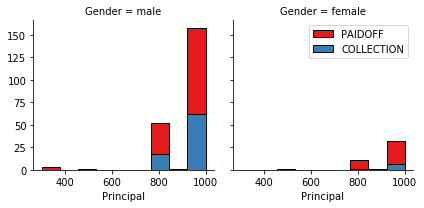

In [347]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

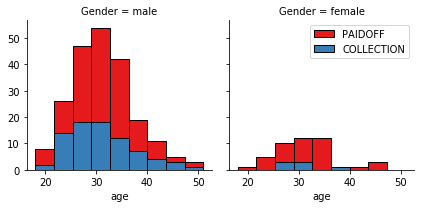

In [348]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

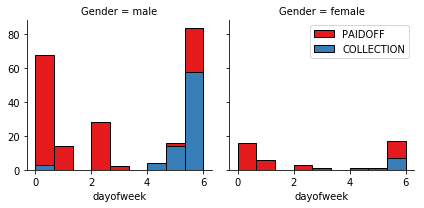

In [349]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [350]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## New Feature: Day of Week Due Date

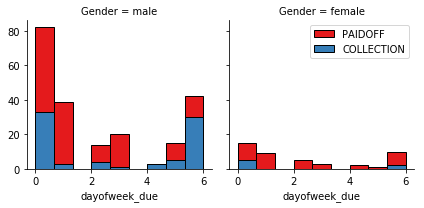

In [351]:
df['dayofweek_due'] = df['due_date'].dt.dayofweek
bins = np.linspace(df.dayofweek_due.min(), df.dayofweek_due.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek_due', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


In [352]:
df['end_days'] = df['dayofweek_due'].apply(lambda x: 1 if (x<=1 or x>=4)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,dayofweek_due,end_days
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0,4,1
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0,4,1
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1,5,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1,5,1


## Convert Categorical features to numerical values

Lets look at gender:

In [353]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [354]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,dayofweek_due,end_days
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,4,1
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,4,1
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,5,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,5,1


## One Hot Encoding  
#### How about education?

In [355]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [357]:
df[['Principal','terms','age','Gender','education', 'weekend', 'end_days', 'dayofweek', 'dayofweek_due']].head()

,Principal,terms,age,Gender,education,weekend,end_days,dayofweek,dayofweek_due
0,1000,30,45,0,High School or Below,0,1,3,4
1,1000,30,33,1,Bechalor,0,1,3,4
2,1000,15,27,0,college,0,0,3,3
3,1000,30,28,1,college,1,1,4,5
4,1000,30,29,0,college,1,1,4,5


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [358]:
Feature = df[['Principal','terms','age','Gender','weekend', 'end_days', 'dayofweek', 'dayofweek_due']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,end_days,dayofweek,dayofweek_due,Bechalor,High School or Below,college
0,1000,30,45,0,0,1,3,4,0,1,0
1,1000,30,33,1,0,1,3,4,1,0,0
2,1000,15,27,0,0,0,3,3,0,0,1
3,1000,30,28,1,1,1,4,5,0,0,1
4,1000,30,29,0,1,1,4,5,0,0,1


### Feature selection

Lets defind feature sets, X:

In [359]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,end_days,dayofweek,dayofweek_due,Bechalor,High School or Below,college
0,1000,30,45,0,0,1,3,4,0,1,0
1,1000,30,33,1,0,1,3,4,1,0,0
2,1000,15,27,0,0,0,3,3,0,0,1
3,1000,30,28,1,1,1,4,5,0,0,1
4,1000,30,29,0,1,1,4,5,0,0,1


What are our lables?

In [360]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [361]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.52,  0.92,  2.33, -0.42, -1.21,  0.4 , -0.26,  0.67, -0.38,
         1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  0.4 , -0.26,  0.67,  2.62,
        -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -2.52, -0.26,  0.26, -0.38,
        -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83,  0.4 ,  0.12,  1.07, -0.38,
        -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83,  0.4 ,  0.12,  1.07, -0.38,
        -0.88,  1.15]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# Split the Data Into Train and Test Set

In [362]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 11) (276,)
Test set: (70, 11) (70,)


## Import Libraries

In [363]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import f1_score

## Helper Function: Confusion Matrix Plot

In [364]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [365]:
from sklearn.neighbors import KNeighborsClassifier

## Training Model and Optimizing Hyperparameters

In [366]:
def run_knn(X_train, y_train, X_test, y_test):
    ks = list(range(1,11))
    accuracies = []
    best_model = 0
    best_accuracy = 0
    best_k = 0
    
    for k in ks:
        #Train Model and Predict  
        neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
#         accuracy = metrics.accuracy_score(y_test, neigh.predict(X_test))
        accuracy = f1_score(y_test, neigh.predict(X_test), average='weighted') 
        
        if accuracy > best_accuracy:
            best_model = neigh
            best_k = k
            best_accuracy = accuracy
        accuracies.append(accuracy)
    return ks, accuracies, best_model, best_accuracy, best_k

In [367]:
ks, accuracies, neigh, best_accuracy, best_k = run_knn(X_train, y_train, X_test, y_test)
best_k

3

## Plot K vs Accuracy

Best k:  3


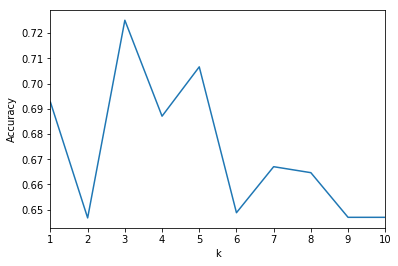

In [368]:
plt.plot(ks, accuracies)
plt.xlim(1, 10)
plt.xlabel("k")
plt.ylabel("Accuracy")

print ("Best k: ", best_k)

### Accuracy Evaluation

In [369]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, neigh.predict(X_test)))

Train set Accuracy:  0.8478260869565217
Test set Accuracy:  0.7285714285714285


              precision    recall  f1-score   support

  COLLECTION       0.36      0.33      0.34        15
     PAIDOFF       0.82      0.84      0.83        55

   micro avg       0.73      0.73      0.73        70
   macro avg       0.59      0.58      0.59        70
weighted avg       0.72      0.73      0.73        70

Confusion matrix, without normalization
[[ 5 10]
 [ 9 46]]


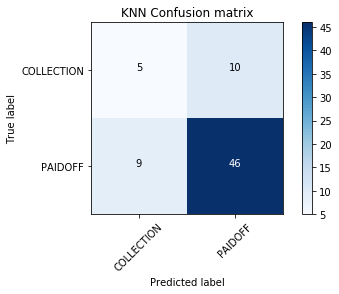

In [370]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, neigh.predict(X_test), labels=["COLLECTION","PAIDOFF"])
np.set_printoptions(precision=2)

print (classification_report(y_test, neigh.predict(X_test)))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='KNN Confusion matrix')

# Decision Tree

In [371]:
from sklearn.tree import DecisionTreeClassifier

loanTree = DecisionTreeClassifier(criterion="entropy", max_depth=10)
loanTree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Train Model

In [372]:
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Prediction

In [373]:
yhat_tree = loanTree.predict(X_test)

print (yhat_tree [0:5])
print (y_test [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [374]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, loanTree.predict(X_test)))

DecisionTrees's Accuracy:  0.7857142857142857


## Visualization

In [40]:
!conda install -c anaconda pydotplus -y

Solving environment: done

# All requested packages already installed.



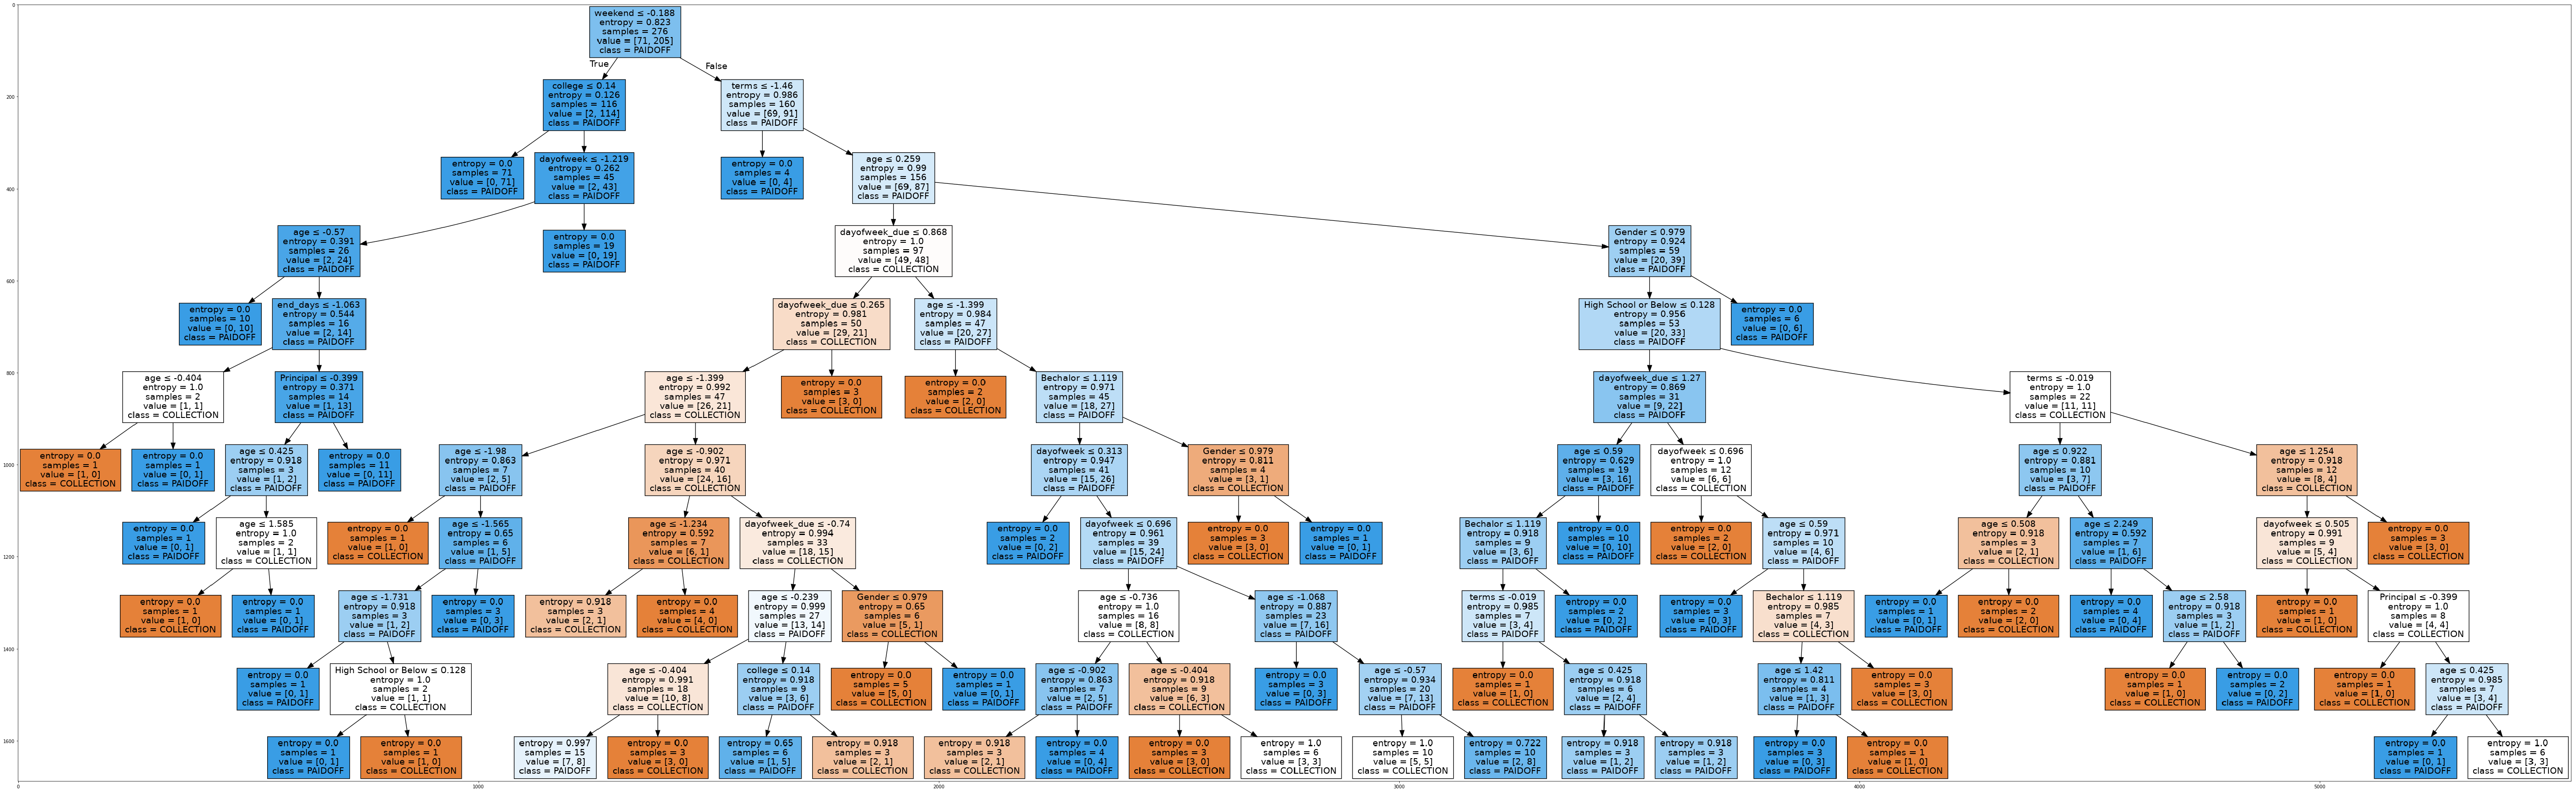

In [375]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

dot_data = StringIO()
filename = "loanstatus.png"
featureNames = Feature.columns
targetNames = list(set(y))
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

## Evaluation

In [376]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanTree.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_tree))

Train set Accuracy:  0.9057971014492754
Test set Accuracy:  0.7857142857142857


              precision    recall  f1-score   support

  COLLECTION       0.50      0.40      0.44        15
     PAIDOFF       0.84      0.89      0.87        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70

Confusion matrix, without normalization
[[ 6  9]
 [ 6 49]]


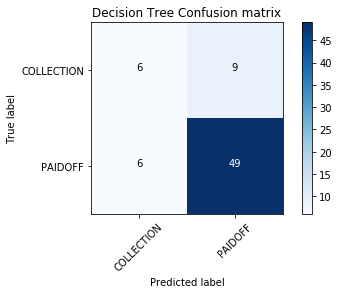

In [377]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, loanTree.predict(X_test), labels=["COLLECTION","PAIDOFF"])
np.set_printoptions(precision=2)

print (classification_report(y_test, loanTree.predict(X_test)))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Decision Tree Confusion matrix')

# Support Vector Machine

In [378]:
from sklearn import svm

## Training the Model and Optimizing Hyperparameters

In [379]:
def do_svm(X_train, y_train, X_test, y_test):
    kernels =["linear", "poly", "rbf", "sigmoid"]
    best_accuracy = 0
    best_model = 0
    best_kernel = 0
    
    for kernel in kernels:
        clf = svm.SVC(kernel=kernel)
        clf.fit(X_train, y_train) 
        ytest_svm = clf.predict(X_test)
        accuracy = f1_score(y_test, ytest_svm, average='weighted') 
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = clf
            best_kernel = kernel
    return best_accuracy, best_model, best_kernel

In [380]:
best_accuracy, clf, best_kernel = do_svm(X_train, y_train, X_test, y_test)
best_kernel

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


'poly'

In [381]:
ytrain_svm = clf.predict(X_train)
ytrain_svm [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [382]:
yhat_svm = clf.predict(X_test)
yhat_svm [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Model Evaluation

              precision    recall  f1-score   support

  COLLECTION       0.67      0.13      0.22        15
     PAIDOFF       0.81      0.98      0.89        55

   micro avg       0.80      0.80      0.80        70
   macro avg       0.74      0.56      0.55        70
weighted avg       0.78      0.80      0.74        70

Confusion matrix, without normalization
[[ 2 13]
 [ 1 54]]


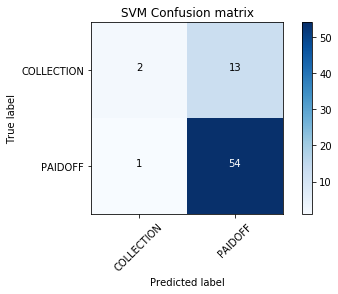

In [383]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_svm, labels=["COLLECTION","PAIDOFF"])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_svm))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='SVM Confusion matrix')

In [384]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, ytrain_svm))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_svm))

Train set Accuracy:  0.7934782608695652
Test set Accuracy:  0.8


# Logistic Regression

In [385]:
from sklearn.linear_model import LogisticRegression

## Training the Model and Optimizing Hyperparameters

In [386]:
def do_LR(X_train,y_train, X_test, y_test):
    solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
    
    best_solver = 0
    best_accuracy = 0
    best_model = 0
    
    for solver in solvers:
        LR = LogisticRegression(C=0.01, solver=solver).fit(X_train,y_train)
        ytest_lr = LR.predict(X_test)
#         accuracy = metrics.accuracy_score(y_test, ytest_lr)
        accuracy = f1_score(y_test, ytest_lr, average='weighted') 
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_solver = solver
            best_model = LR
    return best_solver, best_accuracy, best_model

In [387]:
best_solver, best_accuracy, LR = do_LR(X_train,y_train, X_test, y_test)
best_solver

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'newton-cg'

## Model Prediction and Evaluation

In [388]:
ytrain_lr = LR.predict(X_train)
ytrain_lr[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [389]:
yhat_lr = LR.predict(X_test)
yhat_lr [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [390]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob [0:5]

array([[0.37, 0.63],
       [0.34, 0.66],
       [0.14, 0.86],
       [0.16, 0.84],
       [0.14, 0.86]])

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[ 0 15]
 [ 0 55]]


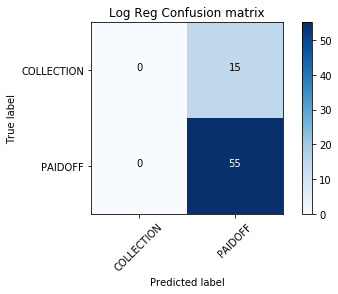

In [391]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_lr, labels=["COLLECTION","PAIDOFF"])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_lr))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Log Reg Confusion matrix')

In [392]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, ytrain_lr))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_lr))

Train set Accuracy:  0.7427536231884058
Test set Accuracy:  0.7857142857142857


In [393]:
print (classification_report(y_test, yhat_lr))


              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Model Evaluation using Test set

In [394]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [395]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-05-09 13:04:09--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-05-09 13:04:09 (246 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [396]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Some pre-processing so test data matches dev data

In [397]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


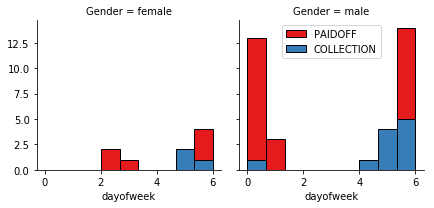

In [398]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

## New Feature: Day of the week Due

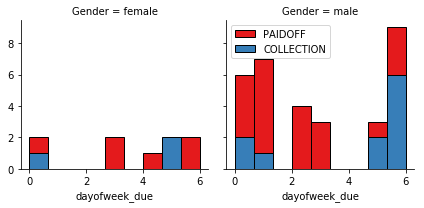

In [399]:
test_df['dayofweek_due'] = test_df['due_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek_due.min(), test_df.dayofweek_due.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek_due', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


In [400]:
test_df['end_days'] = test_df['dayofweek_due'].apply(lambda x: 1 if (x<=1 or x>=4)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,dayofweek_due,end_days
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,4,1
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,3,0
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,6,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,6,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,6,1


In [401]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,dayofweek_due,end_days,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,4,1,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,3,0,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,6,1,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,6,1,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,6,1,1


### Convert male to 0, female to 1

In [402]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,dayofweek_due,end_days,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,4,1,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,3,0,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,6,1,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,6,1,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,6,1,1


In [301]:
Feature_test = test_df[['Principal','terms','age','Gender','weekend', 'end_days', 'dayofweek', 'dayofweek_due']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,end_days,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,1,0,0
1,300,7,35,0,1,0,0,0,0
2,1000,30,43,1,1,1,0,1,0
3,1000,30,26,0,1,1,0,0,1
4,800,15,29,0,1,1,1,0,0


### Setting x and y

In [302]:
X_test_fin = Feature_test
X_test_fin[0:5]

,Principal,terms,age,Gender,weekend,end_days,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,1,0,0
1,300,7,35,0,1,0,0,0,0
2,1000,30,43,1,1,1,0,1,0
3,1000,30,26,0,1,1,0,0,1
4,800,15,29,0,1,1,1,0,0


In [303]:
X_test_fin= preprocessing.StandardScaler().fit(X_test_fin).transform(X_test_fin)
X_test_fin[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  0.45,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -2.24, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77,  0.45, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77,  0.45, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  0.45,  2.4 , -0.8 , -0.86]])

In [304]:
y_test_fin = test_df['loan_status'].values
y_test_fin[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Predict

In [310]:
yhat_knn_test = neigh.predict(X_test_fin)
yhat_tree_test = loanTree.predict(X_test_fin)
ytrain_svm_test = clf.predict(X_test_fin)
yhat_lr_test = LR.predict(X_test_fin)

### F1 Score

In [311]:
from sklearn.metrics import f1_score
f1_score_knn = f1_score(y_test_fin, yhat_knn_test, average='weighted') 
f1_score_tree = f1_score(y_test_fin, yhat_tree_test, average='weighted') 
f1_score_svm = f1_score(y_test_fin, ytrain_svm_test, average='weighted') 
f1_score_lr = f1_score(y_test_fin, yhat_lr_test, average='weighted') 

print ("F1 Scores")
print (".........................................")
print ("KNN : ", f1_score_knn)
print ("Decision Tree: ", f1_score_tree)
print ("Support Vector Machines: ", f1_score_svm)
print ("Logistic Regression: ", f1_score_lr)

F1 Scores
.........................................
KNN :  0.6736355806123249
Decision Tree:  0.6985409652076319
Support Vector Machines:  0.683127572016461
Logistic Regression:  0.6304176516942475


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Jaccard

In [312]:
from sklearn.metrics import jaccard_similarity_score

jaccard_knn = jaccard_similarity_score(y_test_fin, yhat_knn_test) 
jaccard_tree = jaccard_similarity_score(y_test_fin, yhat_tree_test) 
jaccard_svm = jaccard_similarity_score(y_test_fin, ytrain_svm_test) 
jaccard_lr = jaccard_similarity_score(y_test_fin, yhat_lr_test) 

print ("Jaccard Similarity Scores")
print (".........................................")
print ("KNN : ", jaccard_knn)
print ("Decision Tree: ", jaccard_tree)
print ("Support Vector Machines: ", jaccard_svm)
print ("Logistic Regression: ", jaccard_lr)

Jaccard Similarity Scores
.........................................
KNN :  0.7037037037037037
Decision Tree:  0.6851851851851852
Support Vector Machines:  0.7407407407407407
Logistic Regression:  0.7407407407407407


### Logloss

In [313]:
from sklearn.metrics import log_loss

yhat_prob_test = LR.predict_proba(X_test_fin)
Logloss_lr = log_loss(y_test_fin, yhat_prob_test)

### Final Results

In [314]:
Algorithms = ["KNN", "Decision Tree", "SVM", "Logistic Regression"]
Jaccard = [jaccard_knn, jaccard_tree, jaccard_svm, jaccard_lr]
F1_score = [f1_score_knn, f1_score_tree, f1_score_svm, f1_score_lr]
LogLoss = ["?", "?", "?", Logloss_lr]

report = {"Algorithms": Algorithms,
            "Jaccard": Jaccard,
            "F1-score": F1_score,
            "LogLoss": LogLoss}

df_report = pd.DataFrame(report)
df_report

,Algorithms,Jaccard,F1-score,LogLoss
0,KNN,0.703704,0.673636,?
1,Decision Tree,0.685185,0.698541,?
2,SVM,0.740741,0.683128,?
3,Logistic Regression,0.740741,0.630418,0.510242


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>